# Using Logistic Regression to Predict Animal Shelter Adoptions

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

data comes from the Austin Animal Center database: https://data.austintexas.gov/browse?q=austin%20animal%20center&sortBy=relevance&utf8=✓

In [39]:
odf = pd.read_csv('Austin_Animal_Center_Outcomes.csv')

idf = pd.read_csv('Austin_Animal_Center_Intakes.csv')

idf = idf[['Animal ID', 'DateTime', 'Intake Type', 'Intake Condition',
          'Age upon Intake']]

df = pd.merge(left = odf, right = idf, how = 'inner', on = 'Animal ID')
df.shape

(137399, 16)

In [41]:
df = df.rename(columns = {'DateTime_x': 'outcome date',
                         'DateTime_y': 'intake date'})
df = df.drop(['Name', 'MonthYear', 'Outcome Subtype'], axis = 1)
df = df.dropna()
df = df.drop_duplicates(subset = 'Animal ID').reset_index(drop=True)

In [42]:
df['Outcome Type'].value_counts()

Adoption           39899
Transfer           31155
Return to Owner    15115
Euthanasia          7379
Died                 996
Disposal             407
Rto-Adopt            366
Missing               57
Relocate              18
Name: Outcome Type, dtype: int64

In [43]:
df['is adopted'] = [1 if df.loc[i, 'Outcome Type'] == 'Adoption' else 0 for i in range(len(df['Outcome Type']))]
df = df.drop('Outcome Type', axis = 1)

In [44]:
df['Sex upon Outcome'].value_counts()

Neutered Male    31972
Spayed Female    29247
Intact Male      12671
Intact Female    12576
Unknown           8926
Name: Sex upon Outcome, dtype: int64

In [45]:
spayed = []
sex = []
for i in range(len(df)):
    if df.loc[i, 'Sex upon Outcome'] == 'Neutered Male' or df.loc[i, 'Sex upon Outcome'] == 'Spayed Female':
        spayed.append('yes')
    elif df.loc[i, 'Sex upon Outcome'] == 'Unknown':
        spayed.append('unknown')
    else:
        spayed.append('no')
    if df.loc[i, 'Sex upon Outcome'] == 'Neutered Male' or df.loc[i, 'Sex upon Outcome'] == 'Intact Male':
        sex.append('male')
    elif df.loc[i, 'Sex upon Outcome'] == 'Unknown':
        sex.append('unknown')
    else:
        sex.append('female')
df['spayed/neutered'] = spayed
df['sex'] = sex
df = df.drop('Sex upon Outcome', axis = 1)

In [46]:
intake_datetimes= [datetime.strptime(df.loc[i,'intake date'], '%m/%d/%Y %I:%M:%S %p') for i in range(len(df))]
outcome_datetimes= [datetime.strptime(df.loc[i,'outcome date'], '%m/%d/%Y %I:%M:%S %p') for i in range(len(df))]

duration = [outcome - intake for outcome, intake in zip(outcome_datetimes, intake_datetimes)]

days = [(delta.days + 1) if delta.seconds > 43199 else delta.days for delta in duration]

df['stay duration'] = days

In [47]:
birthdays = [datetime.strptime(df.loc[i,'Date of Birth'], '%m/%d/%Y') for i in range(len(df))]
intake_age = [intake - birthday for intake, birthday in zip(intake_datetimes, birthdays)]
df['intake age'] = [(delta.days + 1) if delta.seconds > 43199 else delta.days for delta in intake_age]
outcome_age = [outcome - birthday for outcome, birthday in zip(outcome_datetimes, birthdays)]
df['outcome age'] = [(delta.days + 1) if delta.seconds > 43199 else delta.days for delta in outcome_age]

df = df.drop(['Date of Birth', 'Age upon Outcome', 'outcome date',
              'intake date', 'Age upon Intake'], axis = 1)

In [49]:
def otherize(df, col, cutoff):
    col_counts = dict(df[col].value_counts())
    new_col = []
    for i in range(len(df)):
        if col_counts[df.loc[i, col]] < cutoff:
            new_col.append('other')
        else:
            new_col.append(df.loc[i, col])
    df[col.lower()] = new_col

In [50]:
otherize(df, 'Breed', 600)
otherize(df, 'Color', 1000)
df = df.drop(['Breed', 'Color'], axis = 1)

In [51]:
df.head()

,Animal ID,Animal Type,Intake Type,Intake Condition,is adopted,spayed/neutered,sex,stay duration,intake age,outcome age,breed,color
0,A798016,Cat,Stray,Normal,0,yes,female,79,47,125,Domestic Shorthair,Black
1,A803571,Cat,Stray,Sick,0,unknown,unknown,4,1461,1465,Domestic Shorthair,Black
2,A803373,Dog,Stray,Normal,0,no,male,7,366,372,other,Black/White
3,A803393,Dog,Owner Surrender,Normal,0,no,male,7,1827,1833,other,Brown/White
4,A803610,Cat,Owner Surrender,Normal,1,yes,female,3,154,157,Domestic Shorthair Mix,other


In [53]:
df = pd.get_dummies(df, columns = ['Animal Type', 'Intake Type', 'Intake Condition',
                                  'spayed/neutered', 'sex', 'breed', 'color'])
df.shape

(95392, 73)

In [54]:
X = df.drop(['Animal ID','is adopted'], axis = 1)
y = df['is adopted']
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [56]:
lr = LogisticRegression().fit(X_train, y_train)

score = lr.score(X_test, y_test)
score

/Users/Hunter/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8194817175444482

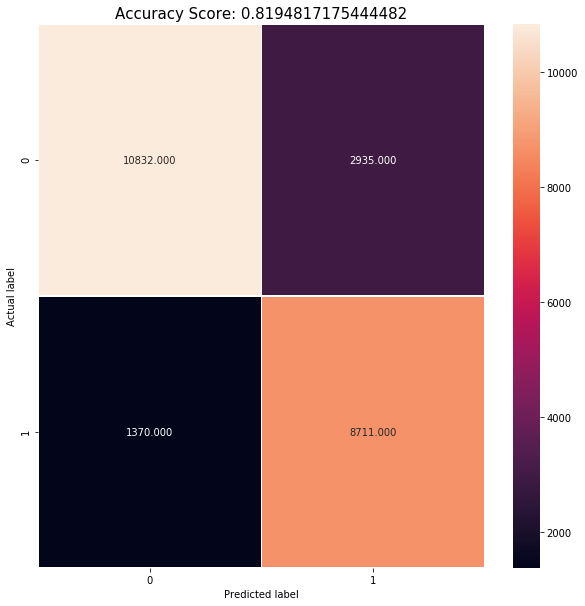

In [59]:
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Accuracy Score: {score}', size = 15)
plt.show()